# CIFAR-10 Data Cleaning and Preparation
This notebook will go through the process used to ready the CIFAR-10 dataset for training a convolutional neural network (CNN).

In [1]:
import sys
print("Python version:", sys.version)
print("Executable:", sys.executable)

Python version: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
Executable: C:\Users\Robert\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe


In [2]:
import torch
import torchvision

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch version: 2.9.1+cpu
Torchvision version: 0.24.1+cpu
CUDA available: False


In [3]:
# Basic tensor test
x = torch.rand(3, 32, 32)
print("Tensor shape:", x.shape)
print("Tensor dtype:", x.dtype)

Tensor shape: torch.Size([3, 32, 32])
Tensor dtype: torch.float32


## Setup: Project paths and data locations

In [4]:
from pathlib import Path

# Project root = folder where the notebook lives (adjust if needed)
PROJECT_ROOT = Path(".").resolve()

DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "Raw Data"
PREP_DIR = DATA_DIR / "Prepared Data"

RAW_DIR.mkdir(parents=True, exist_ok=True)
PREP_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("RAW_DIR:", RAW_DIR)
print("PREP_DIR:", PREP_DIR)
print("\nFiles currently in data/raw:")
for p in sorted(RAW_DIR.glob("*")):
    print(" -", p.name)

PROJECT_ROOT: C:\Users\Robert\Desktop\d802-deep-learning
RAW_DIR: C:\Users\Robert\Desktop\d802-deep-learning\data\Raw Data
PREP_DIR: C:\Users\Robert\Desktop\d802-deep-learning\data\Prepared Data

Files currently in data/raw:
 - CIFAR-10-C.tar
 - cifar-10.zip
 - sampleSubmission.csv
 - test
 - test.7z
 - train
 - train.7z
 - trainLabels.csv


## Verify dataset files (train/test archives and labels)

In [5]:
from pathlib import Path

# Expected files based on the provided CIFAR-10 archive
expected_files = [
    "train.7z",
    "test.7z",
    "trainLabels.csv",
    "sampleSubmission.csv"
]

print("Verifying expected CIFAR-10 files in Raw Data:")
missing = []
for fname in expected_files:
    fpath = RAW_DIR / fname
    exists = fpath.exists()
    print(f" - {fname}: {'FOUND' if exists else 'MISSING'}")
    if not exists:
        missing.append(fname)

if missing:
    raise FileNotFoundError(f"Missing required dataset files: {missing}")

print("\nDataset archive verification complete.")

Verifying expected CIFAR-10 files in Raw Data:
 - train.7z: FOUND
 - test.7z: FOUND
 - trainLabels.csv: FOUND
 - sampleSubmission.csv: FOUND

Dataset archive verification complete.


## Extract train/test archives (7z)

In [ ]:
import py7zr
from pathlib import Path

train_7z = RAW_DIR / "train.7z"
test_7z  = RAW_DIR / "test.7z"

assert train_7z.exists(), f"Missing: {train_7z}"
assert test_7z.exists(), f"Missing: {test_7z}"

print("Extracting train.7z into Raw Data...")
with py7zr.SevenZipFile(train_7z, mode="r") as z:
    z.extractall(path=RAW_DIR)

print("Extracting test.7z into Raw Data...")
with py7zr.SevenZipFile(test_7z, mode="r") as z:
    z.extractall(path=RAW_DIR)

print("Extraction complete.")

## B1) Data Cleaning Process (noise, blur, occlusions, null/erroneous images)
### Tools/Libraries Used

The following tools and libraries will be used throughout the cleaning and preparation process.

- Python 3.11: Primary programming language used for data processing and preprocessing tasks.

- NumPy: Used for numerical operations, array manipulation, validation of image shapes and data types, and normalization of pixel values.

- Matplotlib: Used to visualize sample images and verify the effects of preprocessing steps.

- Pillow (PIL): Used for basic image handling and validation, including loading and inspecting image data.

- PyTorch: Used to represent images as tensors, perform normalization, and support image preprocessing and augmentation using the torchvision library.

- torchvision: Used for standard image transformations, data
  augmentation, and dataset utilities compatible with PyTorch workflows.

- scikit-learn: Used to perform reproducible train, validation, and test dataset splits.

- Jupyter Notebook: Used to document, execute, and demonstrate the data cleaning and preprocessing workflow in an instructional format.

- py7zr: Used to extract compressed CIFAR-10 training and test archives
  (.7z files) in a reproducible and automated manner during data preparation.

The data cleaning process focuses on validating image integrity,
identifying invalid or corrupted images, and preparing the dataset
to be robust to noise, blurriness, and occlusions.

## Inspect extracted train/test folders

In [6]:
from pathlib import Path

train_dir = RAW_DIR / "train"
test_dir  = RAW_DIR / "test"

assert train_dir.exists(), f"Missing train directory: {train_dir}"
assert test_dir.exists(), f"Missing test directory: {test_dir}"

# Look for file extensions
train_files = list(train_dir.glob("*"))
test_files = list(test_dir.glob("*"))

print("Train file count:", len(train_files))
print("Test file count:", len(test_files))

# Show a few filenames and extensions
print("\nTrain sample names:", [p.name for p in train_files[:5]])
print("Train extensions:", sorted({p.suffix.lower() for p in train_files[:200]}))

print("\nTest sample names:", [p.name for p in test_files[:5]])
print("Test extensions:", sorted({p.suffix.lower() for p in test_files[:200]}))

Train file count: 50000
Test file count: 300000

Train sample names: ['1.png', '10.png', '100.png', '1000.png', '10000.png']
Train extensions: ['.png']

Test sample names: ['1.png', '10.png', '100.png', '1000.png', '10000.png']
Test extensions: ['.png']


## Load trainLabels.csv and validate label-file alignment

In [7]:
import pandas as pd

labels_path = RAW_DIR / "trainLabels.csv"
assert labels_path.exists(), f"Missing labels file: {labels_path}"

labels_df = pd.read_csv(labels_path)
print("Labels columns:", labels_df.columns.tolist())
print("Row count:", len(labels_df))
labels_df.head()

Labels columns: ['id', 'label']
Row count: 50000


,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [8]:
from collections import Counter

train_dir = RAW_DIR / "train"
assert train_dir.exists(), f"Missing train directory: {train_dir}"

# Detect the most common extension in train folder
ext_counts = Counter([p.suffix.lower() for p in train_dir.iterdir() if p.is_file()])
if not ext_counts:
    raise RuntimeError("No files found in train directory.")

img_ext = ext_counts.most_common(1)[0][0]
print("Detected image extension:", img_ext)
print("Extension counts (top 5):", ext_counts.most_common(5))

# Build expected filename column
# If ids are numeric, images are typically like "1.png"
labels_df["filename"] = labels_df["id"].astype(str) + img_ext
labels_df[["id", "label", "filename"]].head()

Detected image extension: .png
Extension counts (top 5): [('.png', 50000)]


,id,label,filename
0,1,frog,1.png
1,2,truck,2.png
2,3,truck,3.png
3,4,deer,4.png
4,5,automobile,5.png


## Verify every label has a corresponding image file

In [9]:
train_files = {p.name for p in train_dir.iterdir() if p.is_file()}

missing = labels_df.loc[~labels_df["filename"].isin(train_files), "filename"]
extra = [f for f in list(train_files)[:1000] if f not in set(labels_df["filename"])]  # quick sample check

print("Missing labeled images:", len(missing))
if len(missing) > 0:
    print("First 10 missing:", missing.head(10).tolist())

print("Sample check for extra files not in labels (first 1000 files only):", len(extra))

Missing labeled images: 0
Sample check for extra files not in labels (first 1000 files only): 0


## Encode labels as integers for modeling

In [10]:
# Create stable class mapping
class_names = sorted(labels_df["label"].unique().tolist())
class_to_idx = {name: i for i, name in enumerate(class_names)}

labels_df["label_idx"] = labels_df["label"].map(class_to_idx).astype(int)

print("Classes:", class_names)
print("Class mapping:", class_to_idx)
labels_df.head()

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Class mapping: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


,id,label,filename,label_idx
0,1,frog,1.png,6
1,2,truck,2.png,9
2,3,truck,3.png,9
3,4,deer,4.png,4
4,5,automobile,5.png,1


## Display real labeled images

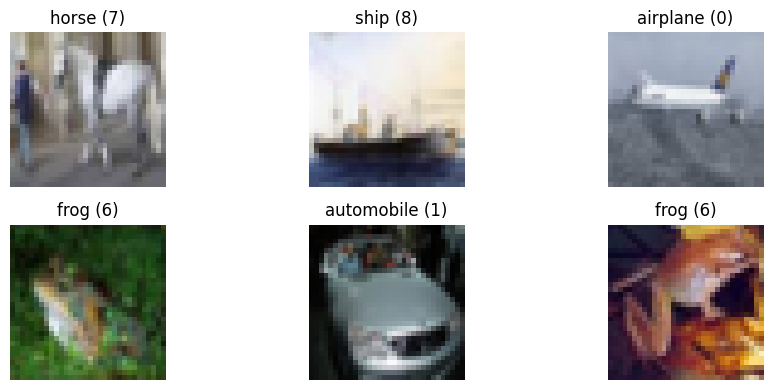

In [11]:
import matplotlib.pyplot as plt
from PIL import Image

sample_df = labels_df.sample(6, random_state=42)

plt.figure(figsize=(10, 4))
for i, row in enumerate(sample_df.itertuples(index=False), start=1):
    img_path = (RAW_DIR / "train" / row.filename)
    img = Image.open(img_path).convert("RGB")

    plt.subplot(2, 3, i)
    plt.imshow(img)
    plt.title(f"{row.label} ({row.label_idx})")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [12]:
img0 = Image.open(RAW_DIR / "train" / labels_df.iloc[0]["filename"]).convert("RGB")
print("Example image size (W,H):", img0.size)

Example image size (W,H): (32, 32)


## B2) Dataset image resolution and proposed training resolution

The CIFAR-10 dataset consists of 32×32 RGB images. This resolution is
preserved during preprocessing to avoid interpolation artifacts.

Although images may appear larger and blurry when displayed, the original
CIFAR-10 images have a native resolution of 32×32 pixels. The apparent
blurriness is due to visualization scaling rather than data quality issues.

In [13]:
# Confirm resolution using a real CIFAR-10 image
from PIL import Image
import numpy as np

sample_img_path = RAW_DIR / "train" / labels_df.iloc[0]["filename"]
img = Image.open(sample_img_path).convert("RGB")

print("Image size (width, height):", img.size)
print("Array shape (H, W, C):", np.array(img).shape)

Image size (width, height): (32, 32)
Array shape (H, W, C): (32, 32, 3)


## B3) Preprocessing goals (normalization and augmentation)

Preprocessing steps include normalization of pixel values and the
application of data augmentation to improve model generalization.

Goals of preprocessing:
Images are converted to tensors and normalized to improve training stability and
speed of convergence. Data augmentation (random horizontal flips and random crops)
is applied to the training set to reduce overfitting and improve generalization.
Augmentation is applied during training-time data loading rather than permanently
modifying stored images.

Augmentations are applied during training to improve robustness rather than permanently altering the stored dataset (Shorten & Khoshgoftaar, 2019; Perez & Wang, 2017).

## Define a PyTorch Dataset for CIFAR-10 images

In [14]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class CifarDiskDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.image_dir / row["filename"]

        # Load image
        img = Image.open(img_path).convert("RGB")

        # Apply transforms
        if self.transform:
            img = self.transform(img)

        # Label as tensor
        label = torch.tensor(int(row["label_idx"]), dtype=torch.long)
        return img, label

## B4) Padding process and when padding occurs

Padding is applied prior to cropping to allow for spatial augmentation
while maintaining a consistent final image size.

Padding process:
Padding is applied before cropping using `RandomCrop(32, padding=4)`. This pads
each image by 4 pixels on each side, then crops back to 32×32, which standardizes
input size while enabling small spatial shifts for robustness (Krizhevsky et al., 2012).

## B5) Number of categories and final layer activation

The CIFAR-10 dataset contains 10 categories. The final dense layer
uses a softmax activation function for multi-class classification.

## B6) Train/validation/test split plan

The dataset is divided into training, validation, and test sets to
enable model tuning and unbiased evaluation.

Train/validation/test split:
Labeled training images are split into training and validation sets using a
stratified split to preserve class balance. The validation set is used for tuning
model hyperparameters and monitoring performance during training. The provided
test set is kept separate for final evaluation/prediction (Goodfellow et al., 2016).

## Create stratified train/validation split

In [15]:
from sklearn.model_selection import train_test_split

# Split using label_idx so class distribution stays balanced
train_df, val_df = train_test_split(
    labels_df,
    test_size=0.10,
    random_state=42,
    stratify=labels_df["label_idx"]
)

print("Train rows:", len(train_df))
print("Val rows:", len(val_df))

# Quick class balance check
print("\nTrain label distribution (top):")
print(train_df["label"].value_counts().head())

print("\nVal label distribution (top):")
print(val_df["label"].value_counts().head())

Train rows: 45000
Val rows: 5000

Train label distribution (top):
label
automobile    4500
frog          4500
bird          4500
ship          4500
horse         4500
Name: count, dtype: int64

Val label distribution (top):
label
horse         500
bird          500
cat           500
truck         500
automobile    500
Name: count, dtype: int64


## Create transforms and DataLoaders

In [16]:
from torchvision import transforms
from torch.utils.data import DataLoader

# CIFAR-10 normalization constants
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std  = (0.2023, 0.1994, 0.2010)

# Training transform: augmentation + normalization
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),   # padding before crop (standard CIFAR practice)
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

# Validation transform: no augmentation, just normalization
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

train_dataset = CifarDiskDataset(train_df, RAW_DIR / "train", transform=train_transform)
val_dataset   = CifarDiskDataset(val_df, RAW_DIR / "train", transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))

Train batches: 352
Val batches: 40


## Sanity check a single batch

In [17]:
images, labels = next(iter(train_loader))
print("Batch images shape:", images.shape)  # expected [batch, 3, 32, 32]
print("Batch labels shape:", labels.shape)  # expected [batch]
print("Label sample:", labels[:10].tolist())
print("Image min/max:", float(images.min()), float(images.max()))

Batch images shape: torch.Size([128, 3, 32, 32])
Batch labels shape: torch.Size([128])
Label sample: [8, 6, 5, 2, 9, 0, 7, 2, 3, 2]
Image min/max: -2.429065704345703 2.7537312507629395


## Create test DataLoader (unlabeled images)

In [18]:
from torch.utils.data import Dataset
from PIL import Image


class CifarTestDiskDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        # sort test images numerically
        self.files = sorted([p for p in image_dir.iterdir() if p.is_file()],
                            key=lambda p: int(p.stem) if p.stem.isdigit() else p.stem)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, img_path.name  # keep filename for later reference


test_dir = RAW_DIR / "test"
test_dataset = CifarTestDiskDataset(test_dir, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0)

print("Test images:", len(test_dataset))
print("Test batches:", len(test_loader))

Test images: 300000
Test batches: 2344


## Visual check of a transformed batch

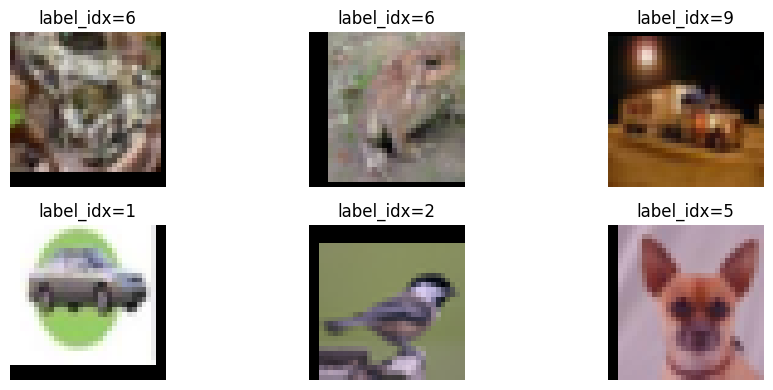

In [19]:
import matplotlib.pyplot as plt
import torch


def unnormalize(img_tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return img_tensor * std + mean


images, labels = next(iter(train_loader))
imgs = images[:6].cpu()

plt.figure(figsize=(10, 4))
for i in range(6):
    img = unnormalize(imgs[i], cifar10_mean, cifar10_std)
    img = img.clamp(0, 1).permute(1, 2, 0).numpy()
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"label_idx={int(labels[i])}")
    plt.axis("off")
plt.tight_layout()
plt.show()

## C) Saved prepared dataset artifact

The prepared dataset is saved after preprocessing to support
reproducibility and evaluation.

## Save prepared dataset manifest (splits and label mapping)

In [22]:
import json

# Ensure Prepared Data folder exists
PREP_DIR.mkdir(parents=True, exist_ok=True)

# Save splits as CSV
train_csv = PREP_DIR / "train_split.csv"
val_csv   = PREP_DIR / "val_split.csv"

train_df[["id", "filename", "label", "label_idx"]].to_csv(train_csv, index=False)
val_df[["id", "filename", "label", "label_idx"]].to_csv(val_csv, index=False)

# Save class mapping
mapping_path = PREP_DIR / "class_mapping.json"
with open(mapping_path, "w", encoding="utf-8") as f:
    json.dump({"class_names": class_names, "class_to_idx": class_to_idx}, f, indent=2)

# Save preprocessing configuration (documents normalization, augmentation, and padding)
prep_config = {
    "image_resolution": [32, 32, 3],
    "tensor_format": "CHW",
    "normalization": {"mean": cifar10_mean, "std": cifar10_std},
    "train_augmentations": ["RandomHorizontalFlip()", "RandomCrop(32, padding=4)"],
    "val_augmentations": [],
    "padding": {"method": "RandomCrop padding", "padding_pixels": 4, "when": "before crop"},
    "split": {"train": len(train_df), "val": len(val_df)},
    "test_images": len(test_dataset),
    "notes": "Raw images remain in data/Raw Data and are not committed to Git due to size."
}

config_path = PREP_DIR / "prepared_dataset_config.json"
with open(config_path, "w", encoding="utf-8") as f:
    json.dump(prep_config, f, indent=2)

print("Saved:")
print(" -", train_csv)
print(" -", val_csv)
print(" -", mapping_path)
print(" -", config_path)

Saved:
 - C:\Users\Robert\Desktop\d802-deep-learning\data\Prepared Data\train_split.csv
 - C:\Users\Robert\Desktop\d802-deep-learning\data\Prepared Data\val_split.csv
 - C:\Users\Robert\Desktop\d802-deep-learning\data\Prepared Data\class_mapping.json
 - C:\Users\Robert\Desktop\d802-deep-learning\data\Prepared Data\prepared_dataset_config.json


## Save a small prepared sample file

In [21]:
import numpy as np
import torch

# Manageable sample size
SAMPLE_N = 2000

# Pull SAMPLE_N items from the training dataset after transforms
sample_images = []
sample_labels = []

for i in range(SAMPLE_N):
    img_t, label_t = train_dataset[i]
    sample_images.append(img_t.numpy())
    sample_labels.append(int(label_t))

X_sample = np.stack(sample_images, axis=0)  # [N, 3, 32, 32]
y_sample = np.array(sample_labels, dtype=np.int64)

out_npz = PREP_DIR / f"prepared_sample_train_{SAMPLE_N}.npz"
np.savez_compressed(
    out_npz,
    X=X_sample,
    y=y_sample,
    class_names=np.array(class_names)
)

print("Saved sample npz:", out_npz)
print("Shape:", X_sample.shape, y_sample.shape)
print("Size (MB):", round(out_npz.stat().st_size / (1024*1024), 2))

Saved sample npz: C:\Users\Robert\Desktop\d802-deep-learning\data\Prepared Data\prepared_sample_train_2000.npz
Shape: (2000, 3, 32, 32) (2000,)
Size (MB): 7.52


Because the complete prepared dataset exceeds practical repository size
limits, a representative prepared dataset file is included, and the full
prepared dataset is fully reproducible using the provided split files and
preprocessing configuration.